<a href="https://colab.research.google.com/github/jacquesbilombe/FashionClassifier/blob/main/fashionclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset for this project can be found on the project's GitHub repository or at [Kaggle](https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full?rvi=1). This project serves as a case study for the Data Science and Analytics course at PUC RIO.
For more information, please refer to the project README.

## Importing libraries

In [1]:
import os
import cv2 # opencv lib
import csv
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path
from keras.optimizers import Adam
from tensorflow.keras import Model
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Other configurations

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

# Get the data access
! git clone https://github.com/jacquesbilombe/FashionClassifier.git

fatal: destination path 'FashionClassifier' already exists and is not an empty directory.


## Preprocessing

### Data importation

In [3]:
# Files path
data_folder = os.path.join('FashionClassifier', 'dataset')

imgs_path = data_folder + '/' + 'Images'
img_id = pd.DataFrame(pd.read_csv(data_folder + '/' + 'images_details.csv'))
img_id.head(5)

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [4]:
img_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      5403 non-null   object
 1   sender_id  5403 non-null   int64 
 2   label      5403 non-null   object
 3   kids       5403 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 132.0+ KB


In [5]:
images_names = os.listdir(imgs_path)
images_names[:5], print(img_id.columns)

Index(['image', 'sender_id', 'label', 'kids'], dtype='object')


(['e04c6715-e743-4645-8955-03e86801ec25.jpg',
  '5e20fec3-814f-4d03-bd88-4b72a0e2ea53.jpg',
  'ecfd00ef-2fe1-4778-a2a8-e97aeb810f26.jpg',
  'f72d9ae5-b2b7-4c2e-83c0-d7e1d6cf3404.jpg',
  '22ee2330-a2e7-4abf-aec1-0699e819a248.jpg'],
 None)

### Data Cleaning

For a classification problem, we only need the image ID and its label (target), so we can drop the other columns

In [6]:
# For a classification problem
df_images = pd.DataFrame(img_id['image'] + '.jpg')
df_images['target'] = img_id['label']
df_images.head(5)

,image,target
0,4285fab0-751a-4b74-8e9b-43af05deee22.jpg,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d.jpg,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,Shoes


In [7]:
# Calculate the value counts of unique labels
counts = df_images['target'].value_counts()

# Create a bar chart using plotly express
target_count = px.bar(x=counts.index, y=counts.values,
                      labels={'x': 'Label', 'y': 'Count'},
                      title='Label Categories',
                      text=counts.values)
target_count.show()

As shown above, some label categories have fewer than 40 items in the dataset, so we can apply a threshold of 40. Moreover, we don't have information about the "Not sure" and "Other" categories, so we'll drop them from the dataset.

In [8]:
list_unwaned = ['Other', 'Not sure']

# Get the label with its count less than 40
df_threshold = counts.reset_index()
df_threshold.columns = ['target', 'count']
df_threshold = df_threshold.loc[df_threshold['count'] < 40]

# final list
list_unwaned = list_unwaned + list(df_threshold['target'].values)
list_unwaned

['Other', 'Not sure', 'Blouse', 'Skip']

In [9]:
# Drop the unwanted labels
df_images = df_images[~df_images['target'].isin(list_unwaned)]


In [10]:
 # Calculate the value counts of unique labels
counts = df_images['target'].value_counts()

# Create a bar chart using plotly express
target_count = px.bar(x=counts.index, y=counts.values,
                      labels={'x': 'Label', 'y': 'Count'},
                      title='Label Categories',
                      text=counts.values)
target_count.show()

#### Check if some images cannot be open by the image processing algorithms

In [11]:
corrupted_img = list()
path = Path(imgs_path).rglob("*.jpg")
for img_dir in path:
    try:
      image = cv2.imread(str(img_dir))
      # Perform operations on the image
    except cv2.error as e:
        corrupted_img.append(str(img_dir))

# Drop the corrupted images from the dataset
df_images = df_images[~df_images['image'].isin(corrupted_img)]

array([[[184, 208, 220],
        [184, 208, 220],
        [184, 208, 220],
        ...,
        [178, 197, 210],
        [178, 197, 210],
        [178, 197, 210]],

       [[184, 208, 220],
        [184, 208, 220],
        [184, 208, 220],
        ...,
        [178, 197, 210],
        [178, 197, 210],
        [178, 197, 210]],

       [[185, 209, 221],
        [185, 209, 221],
        [184, 208, 220],
        ...,
        [179, 198, 211],
        [179, 198, 211],
        [179, 198, 211]],

       ...,

       [[221, 231, 248],
        [208, 219, 233],
        [216, 227, 241],
        ...,
        [200, 217, 230],
        [199, 216, 229],
        [198, 215, 228]],

       [[217, 227, 244],
        [221, 232, 246],
        [204, 215, 229],
        ...,
        [200, 217, 230],
        [199, 216, 229],
        [198, 215, 228]],

       [[210, 220, 237],
        [208, 219, 233],
        [163, 174, 188],
        ...,
        [200, 217, 230],
        [199, 216, 229],
        [198, 215, 228]]], dtype=uint8)
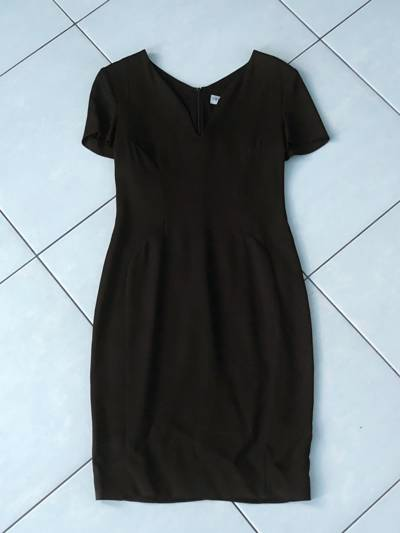

In [14]:
image

### Data Visualization

Before setting the model parameters or splitting the dataset into train and test, we're going to see if each image matches its label.